<a href="https://colab.research.google.com/github/khalidpark/machinelearning_whitepaper/blob/main/Machine_learning_whitepaper_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Kaggle 데이터세트에서 10% 샘플링된 데이터입니다.
## Source: https://www.kaggle.com/wordsforthewise/lending-club
## 10% of expired loans (loan_status: ['Fully Paid' and 'Charged Off'])
## grades A-D
## term ' 36 months'

df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/lending_club/lending_club_sampled.csv')
df['issue_d'] = pd.to_datetime(df['issue_d'], infer_datetime_format=True)

# issue_d로 정렬
df = df.set_index('issue_d').sort_index()

df['interest_rate'] = df['int_rate'].astype(float)
df['monthly_debts'] = df['annual_inc'] / 12 * df['dti'] / 100

# 152 특성 중 6특성만 사용
columns = ['annual_inc', # 연수입
           'fico_range_high', # 신용점수 
           'funded_amnt', # 대출
           'title', # 대출 목적
           'monthly_debts', # 월간 부채
           'interest_rate'] # 이자율

df = df[columns]
df = df.dropna()

# 마지막 10,000 대출은 테스트셋
# 테스트셋 전 10,000 대출이 검증셋
# 나머지는 학습셋
test = df[-10000:]
val = df[-20000:-10000]
train = df[:-20000]

In [ ]:
df.columns

Index(['annual_inc', 'fico_range_high', 'funded_amnt', 'title',
       'monthly_debts', 'interest_rate'],
      dtype='object')

In [ ]:
test.shape, val.shape, train.shape

((10000, 6), (10000, 6), (76408, 6))

In [ ]:
# 타겟은 이자율
target = 'interest_rate' 
features = df.columns.drop('interest_rate')

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

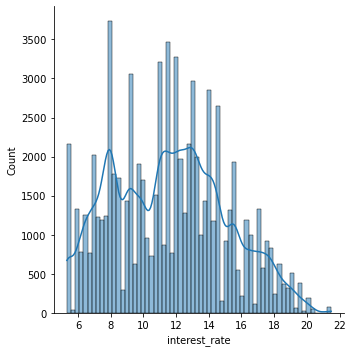

In [ ]:
# 타겟이 약간 right skewed 되어 있으나 큰 문제는 아닙니다.
%matplotlib inline
import seaborn as sns
sns.displot(y_train, kde=True);

### 선형회귀 학습

In [ ]:
from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

linear = make_pipeline(
    TargetEncoder(),  
    LinearRegression()
)

linear.fit(X_train, y_train)
print('R^2', linear.score(X_val, y_val))

R^2 0.17585064958162422


### 그래디언트 부스팅으로 학습을 진행해 보겠습니다.

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터

boosting = XGBRegressor(
    n_estimators=1000,
    objective='reg:squarederror', # default
    learning_rate=0.2,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

boosting.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=50
         )

[0]	validation_0-rmse:9.44760	validation_1-rmse:10.18662
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:7.74920	validation_1-rmse:8.52176
[2]	validation_0-rmse:6.42741	validation_1-rmse:7.23395
[3]	validation_0-rmse:5.41177	validation_1-rmse:6.24461
[4]	validation_0-rmse:4.64239	validation_1-rmse:5.48752
[5]	validation_0-rmse:4.07029	validation_1-rmse:4.91294
[6]	validation_0-rmse:3.65579	validation_1-rmse:4.48858
[7]	validation_0-rmse:3.35895	validation_1-rmse:4.16951
[8]	validation_0-rmse:3.15275	validation_1-rmse:3.94344
[9]	validation_0-rmse:3.00916	validation_1-rmse:3.77479
[10]	validation_0-rmse:2.90927	validation_1-rmse:3.65312
[11]	validation_0-rmse:2.84186	validation_1-rmse:3.56173
[12]	validation_0-rmse:2.79511	validation_1-rmse:3.49381
[13]	validation_0-rmse:2.76404	validation_1-rmse:3.44970
[14]	validation_0-rmse:2.74017	validation_1-rmse:3.4

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.2, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [ ]:
y_pred = boosting.predict(X_val_encoded)
print('R^2', r2_score(y_val, y_pred))

R^2 0.22947518106177134


### 그래디언트 부스팅 결과를 해석하려면??

선형모델은 회귀계수(coefficients)를 이용해 변수와 타겟 관계를 해석할 수 있지만 트리모델은 할 수 없습니다.

대신 부분의존그림(Partial dependence plots)을 사용하여 개별 특성과 타겟간의 관계를 볼 수 있습니다.

### PDP (1 특성 사용)

In [ ]:
# dpi(dots per inch) 수치를 조정해 이미지 화질을 조정 할 수 있습니다
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

#### 선형회귀모델에서 `annual_inc` 특성의 PDP를 그려보겠습니다.

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'annual_inc'

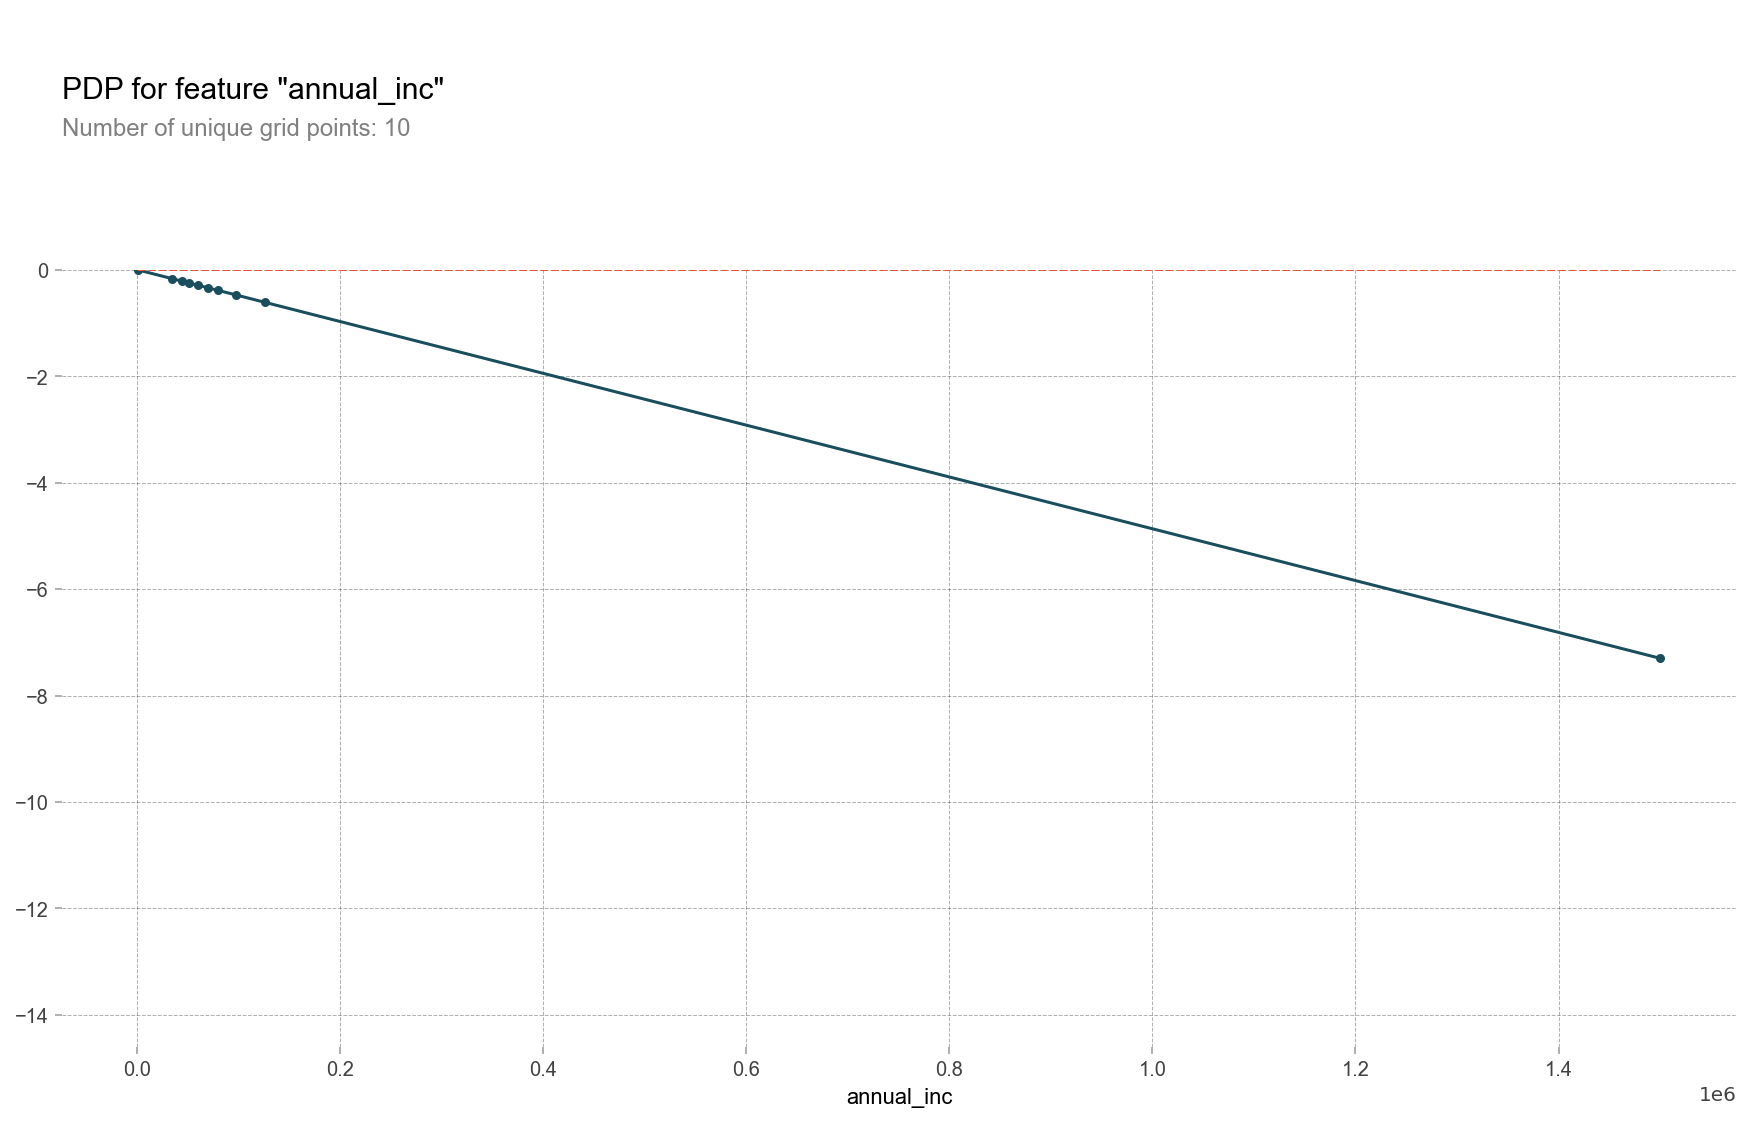

In [ ]:
isolated = pdp_isolate(
    model=linear, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

#### 그래디언트 부스팅 모델에서 `annual_inc` PDP를 그려보겠습니다.

In [ ]:
isolated = pdp_isolate(
    model=boosting, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

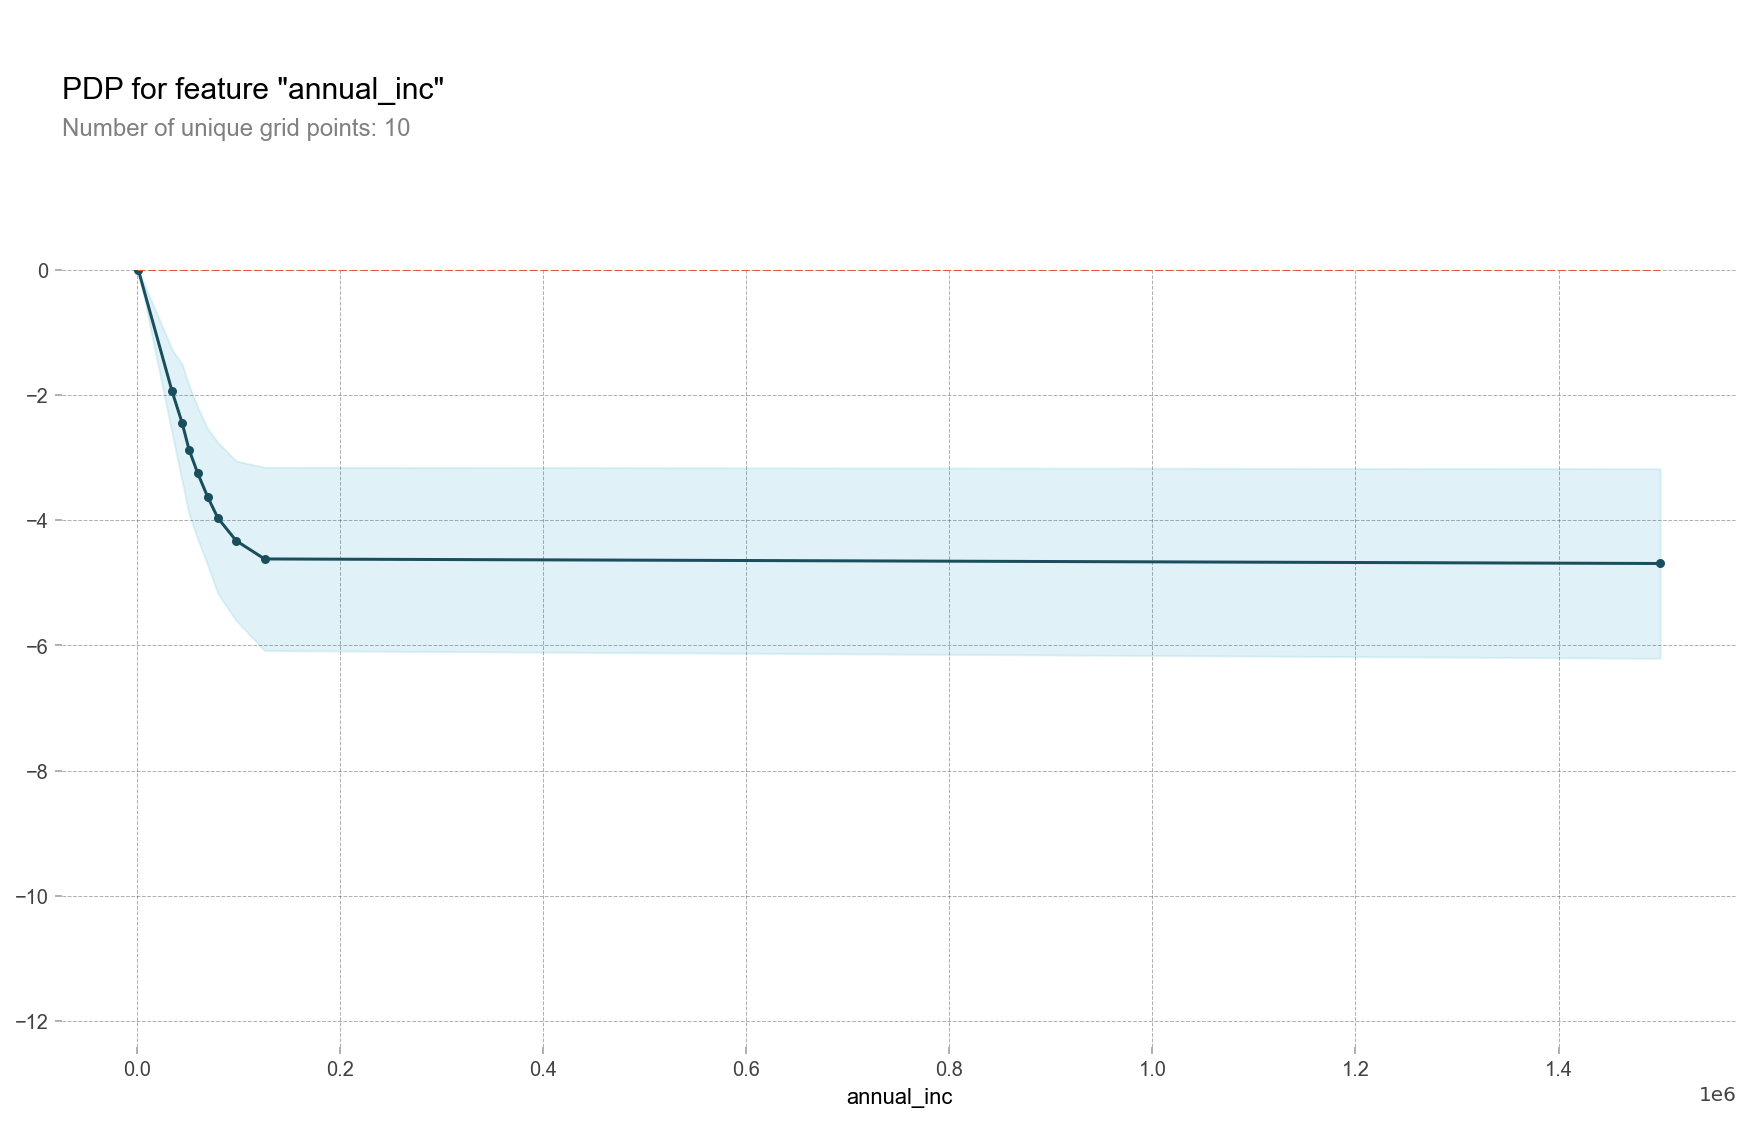

In [ ]:
pdp_plot(isolated, feature_name=feature);

일부분을 확대하면

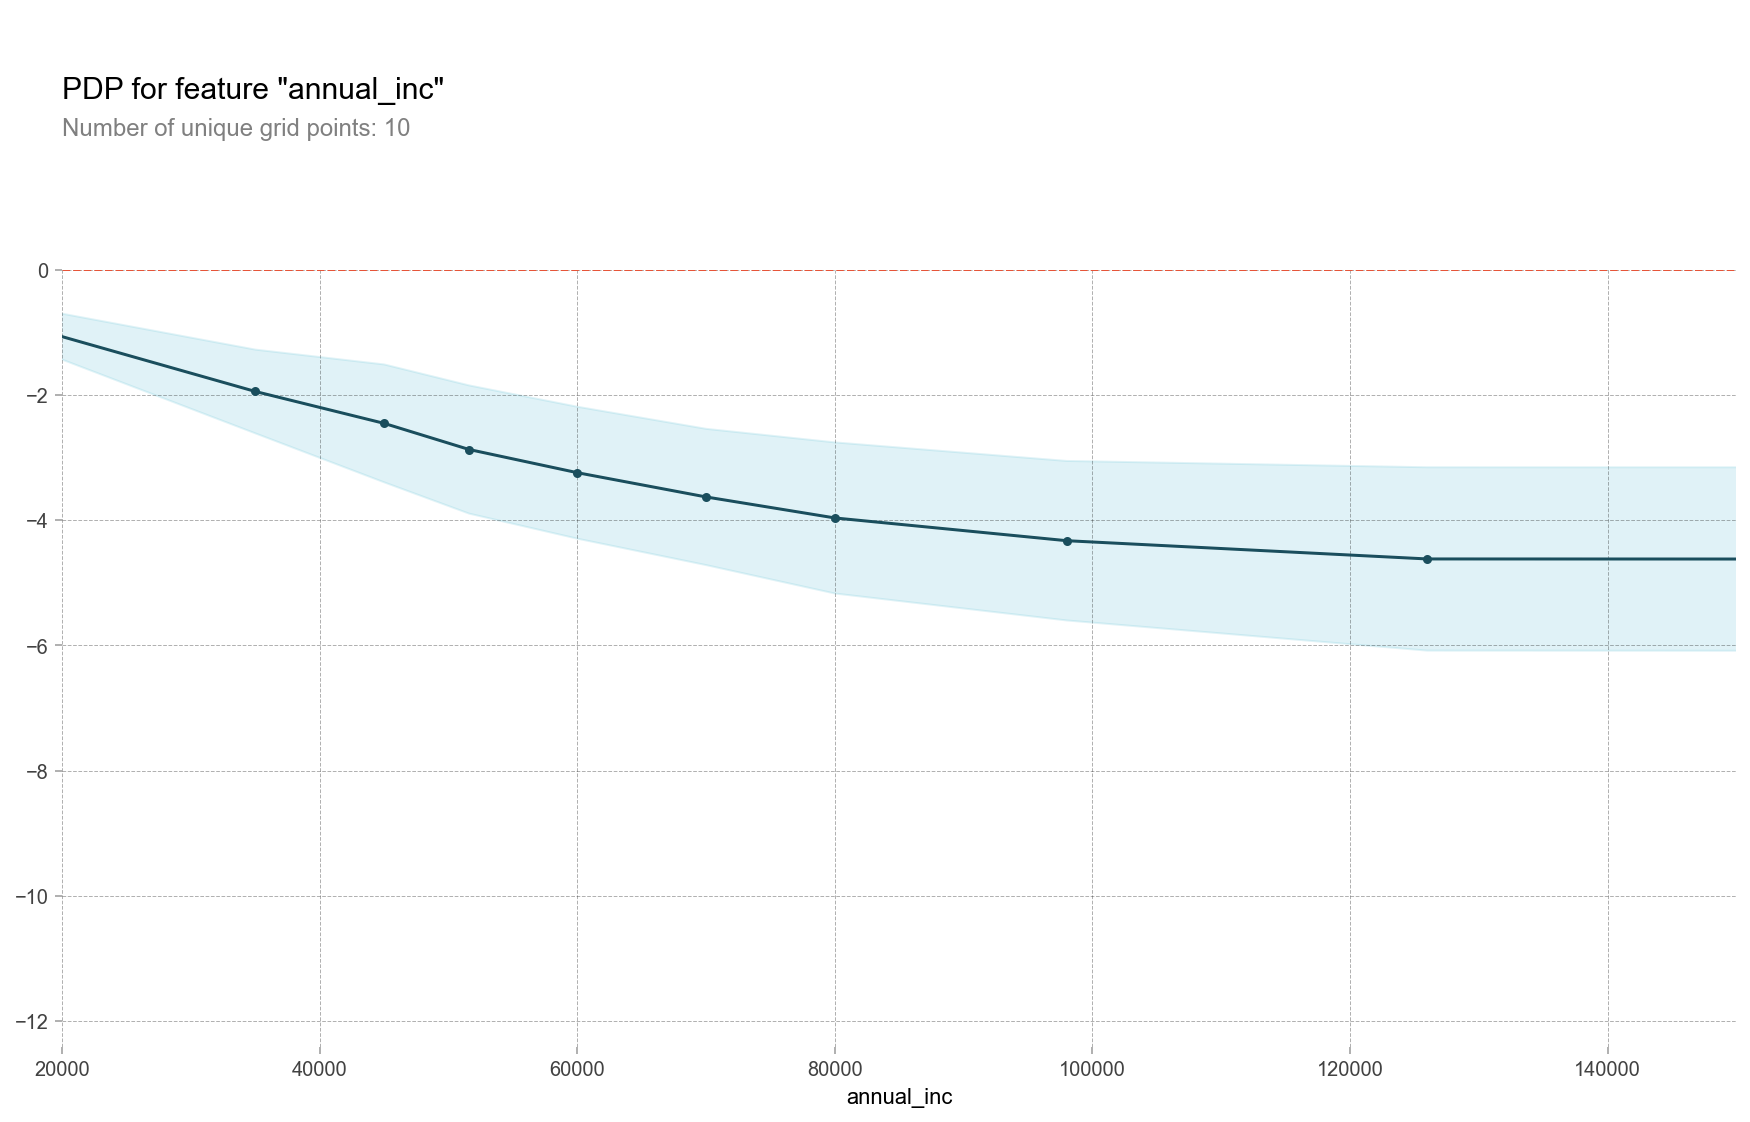

In [ ]:
pdp_plot(isolated, feature_name=feature)
plt.xlim((20000,150000));

#### PDP 를 10개의 ICE(Individual Conditional Expectation) curves와 함께 그려보겠습니다.
한 ICE 곡선은 하나의 관측치에 대해 관심 특성을 변화시킴에 따른 타겟값 변화 곡선이고 이 ICE들의 평균이 PDP 입니다.

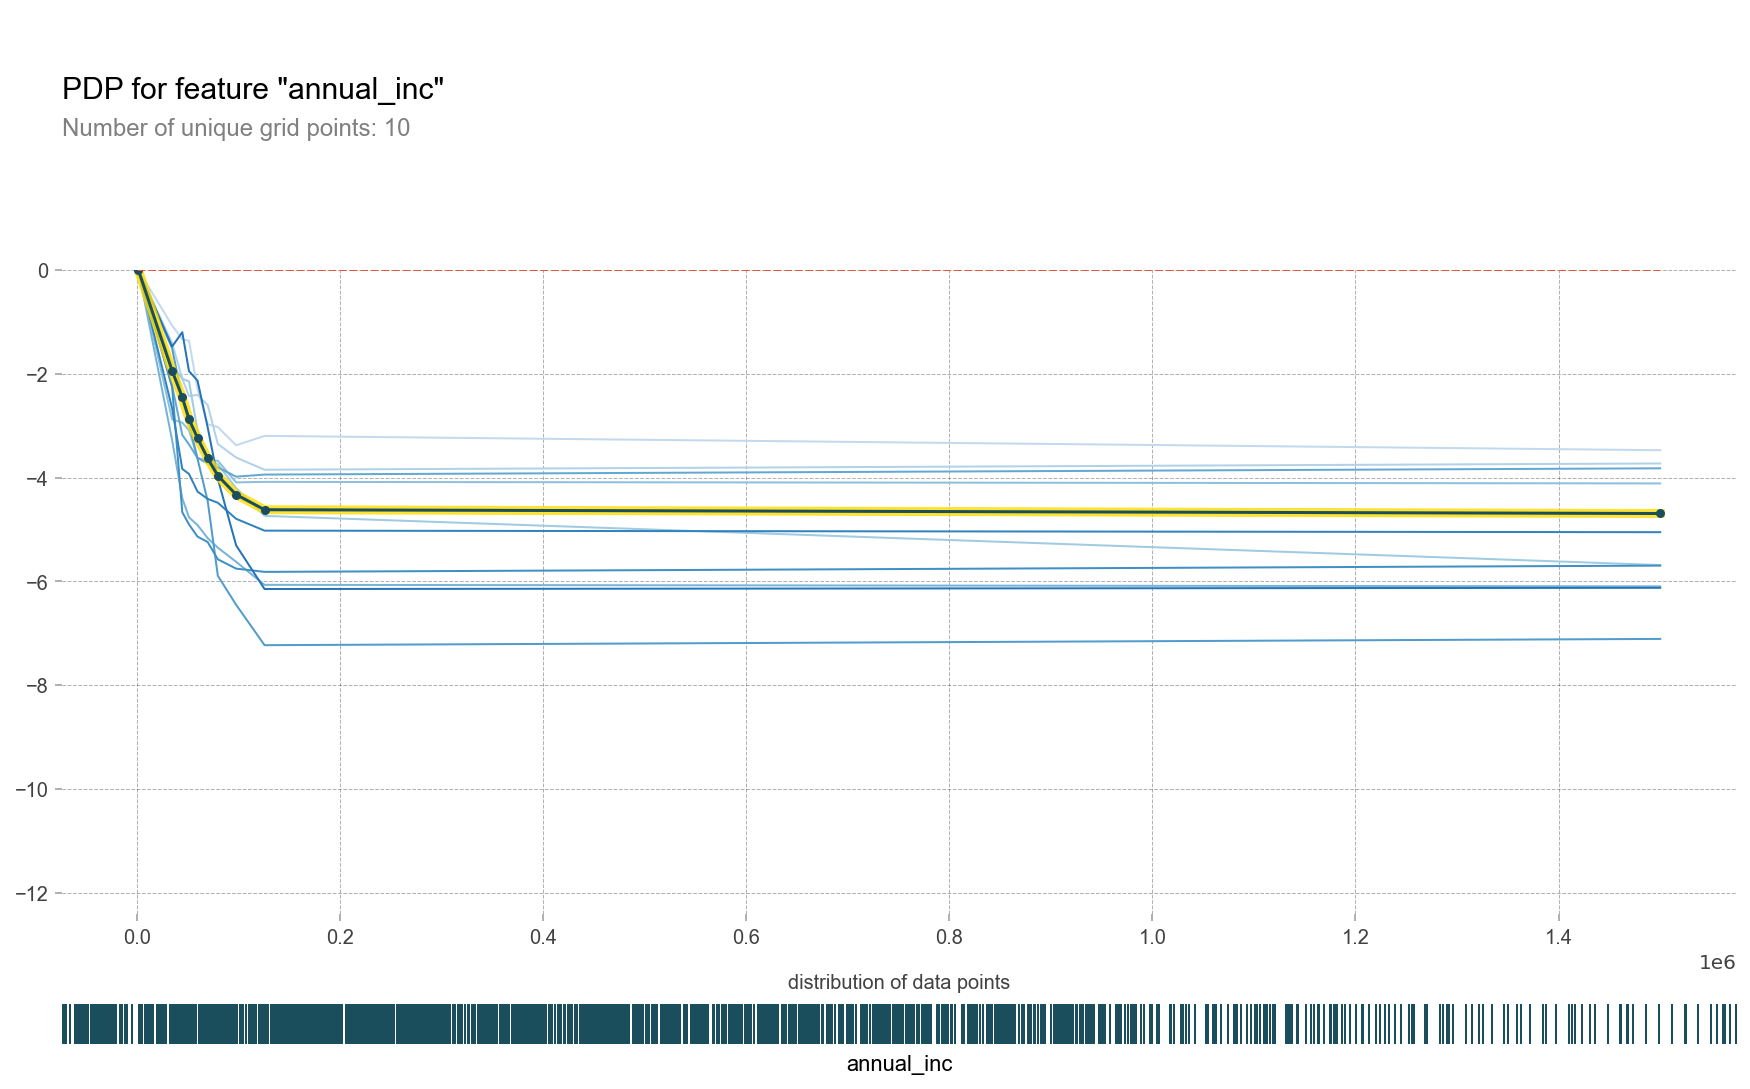

In [ ]:
pdp_plot(isolated
         , feature_name=feature
         , plot_lines=True # ICE plots
         , frac_to_plot=0.001 # or 10 (# 10000 val set * 0.001)
         , plot_pts_dist=True) 

plt.xlim(20000,150000);

In [ ]:
X_val_encoded['annual_inc'].value_counts()

60000.00    391
50000.00    388
65000.00    290
70000.00    282
40000.00    271
           ... 
52850.00      1
39998.40      1
29498.00      1
65101.71      1
15360.00      1
Name: annual_inc, Length: 1386, dtype: int64

#### ICE curves -> PDP 를 표현하는 GIF 입니다
[Christoph Molnar](https://twitter.com/ChristophMolnar/status/1066398522608635904)

##### 한 특성에 대해 PDP를 그릴 경우 얼마나 많은 예측이 필요할까요?
데이터셋 사이즈에 grid points를 곱한 수 만큼 예측을 해야 합니다.


In [ ]:
isolated = pdp_isolate(
    model=boosting, 
    dataset=X_val_encoded, 
    model_features=X_val.columns, 
    feature=feature,
    # grid point를 크게 주면 겹치는 점이 생겨 Number of unique grid points는 grid point 보다 작을 수 있습니다.
    num_grid_points=100, # grid 포인트를 더 줄 수 있습니다. default = 10
)


In [ ]:
print('예측수: ',len(X_val) * 100)

예측수:  1000000


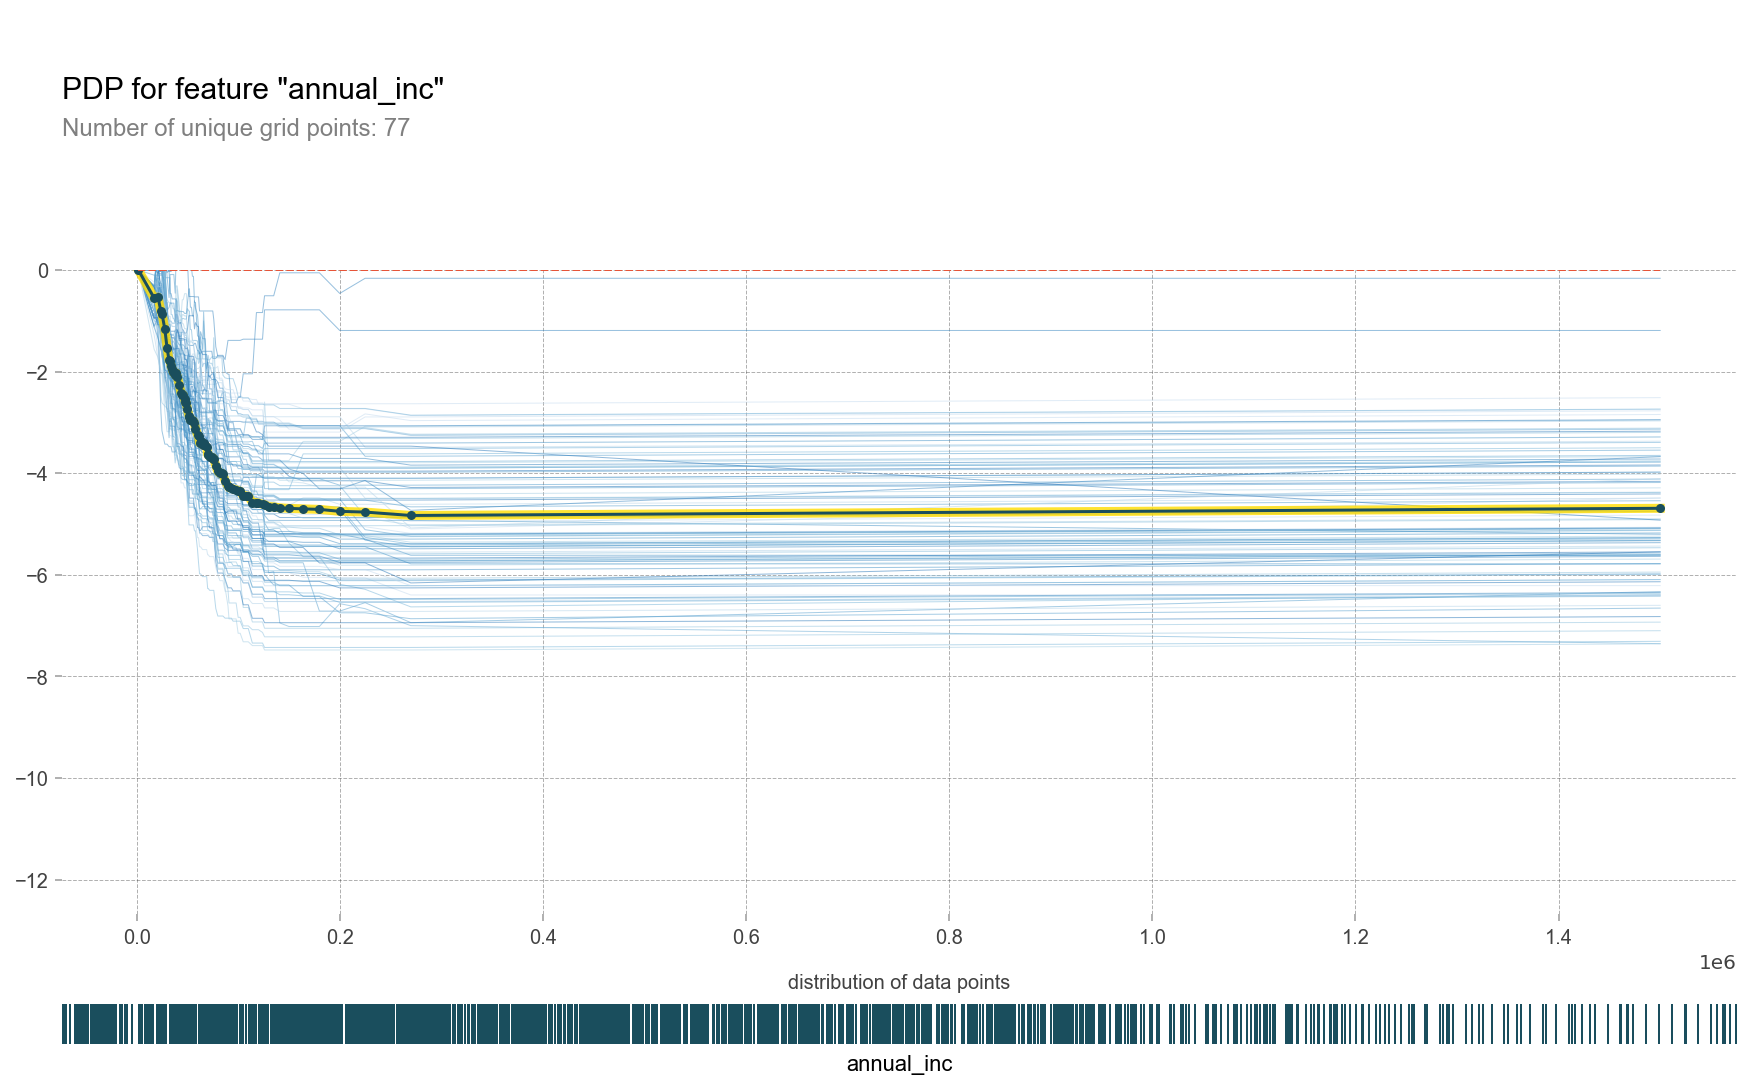

In [ ]:
pdp_plot(isolated
         , feature_name=feature
         , plot_lines=True
         , frac_to_plot=0.01 # ICE curves는 100개
         , plot_pts_dist=True )

plt.xlim(20000,150000);

### PDP (2 특성 사용)

이번에는 **두 특성간의 상호작용**을 PDP를 통해 확인해 보겠습니다.

---
(참고: PDPBox version <= 0.20 과 몇몇 matplotlib 버전에서 `pdp_interact_plot`에서`plot_type='contour'` 설정시 에러가 발생할 수 있습니다.
`TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'`
다음 링크를 확인해 주세요 https://github.com/SauceCat/PDPbox/issues/40)

---

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [ ]:
features = ['annual_inc', 'fico_range_high']

interaction = pdp_interact(
    model=boosting, 
    dataset=X_val_encoded,
    model_features=X_val.columns, 
    features=features
)

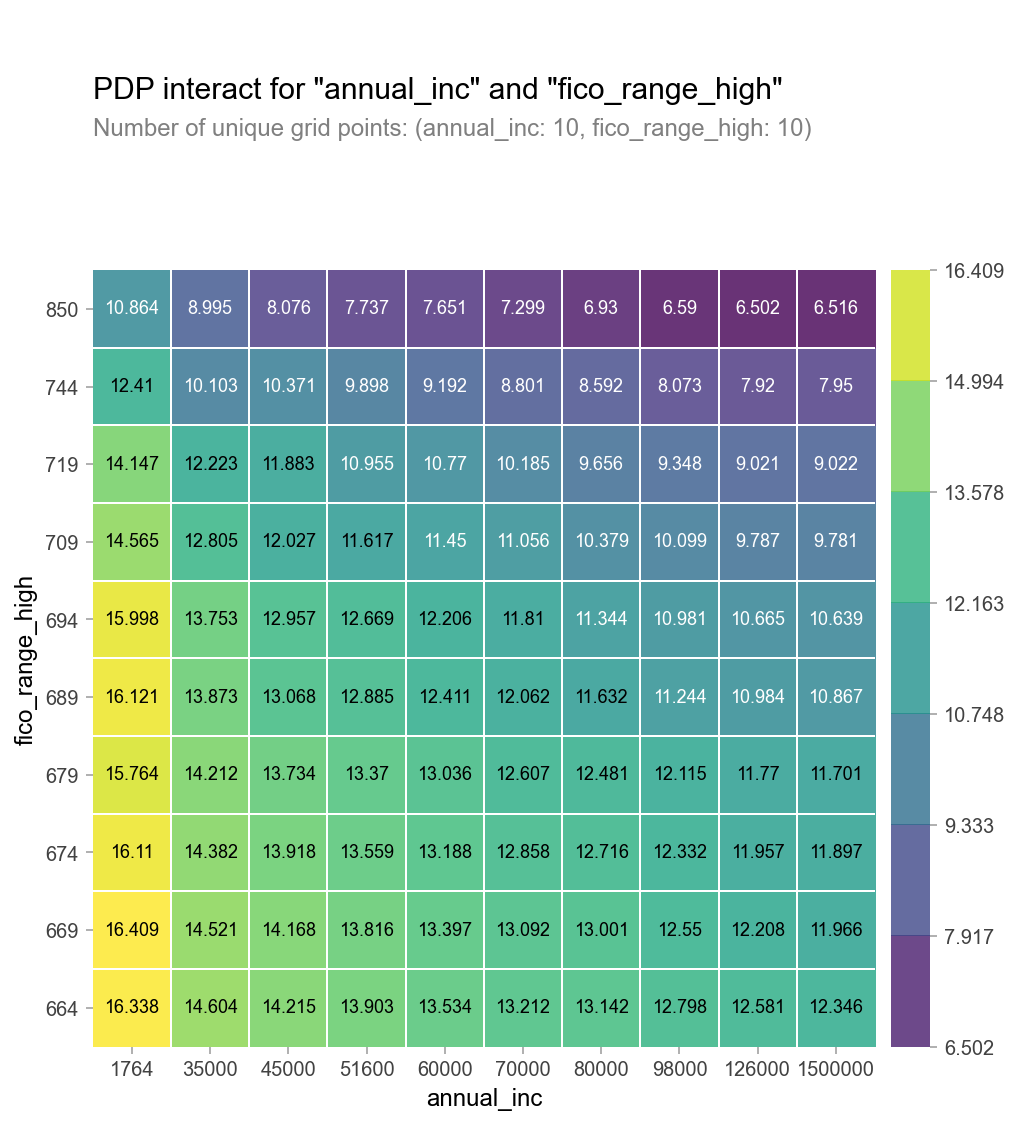

In [ ]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

### PDP를 Plotly를 사용하여 3D로 보여줄 수 있습니다

In [ ]:
features

['annual_inc', 'fico_range_high']

In [ ]:
# 2D PDP dataframe
interaction.pdp

annual_inc  fico_range_high      preds
0       1764.0            664.0  16.338432
1       1764.0            669.0  16.408806
2       1764.0            674.0  16.110056
3       1764.0            679.0  15.763701
4       1764.0            689.0  16.120836
..         ...              ...        ...
95   1500000.0            694.0  10.639333
96   1500000.0            709.0   9.780721
97   1500000.0            719.0   9.021660
98   1500000.0            744.0   7.949769
99   1500000.0            850.0   6.515942

[100 rows x 3 columns]

In [ ]:
type(interaction.pdp)

pandas.core.frame.DataFrame

In [ ]:
# 위에서 만든 2D PDP를 테이블로 변환(using Pandas, df.pivot_table)하여 사용합니다

pdp = interaction.pdp.pivot_table(
    values='preds', # interaction['preds']
    columns=features[0], 
    index=features[1]
)[::-1] # 인덱스를 역순으로 만드는 slicing입니다

In [ ]:
pdp

annual_inc       1764.0     35000.0    45000.0    51600.0    60000.0    \
fico_range_high                                                          
850.0            10.864302   8.995165   8.075720   7.737293   7.651024   
744.0            12.409744  10.103258  10.370611   9.898315   9.192068   
719.0            14.147110  12.223467  11.883232  10.955293  10.769902   
709.0            14.564993  12.805396  12.027140  11.616870  11.450089   
694.0            15.998167  13.752608  12.956696  12.668674  12.205635   
689.0            16.120836  13.872971  13.068296  12.884528  12.410858   
679.0            15.763701  14.211788  13.733863  13.369506  13.036220   
674.0            16.110056  14.381800  13.918399  13.558845  13.188469   
669.0            16.408806  14.520775  14.168143  13.815951  13.396511   
664.0            16.338432  14.604440  14.214828  13.903196  13.533888   

annual_inc       70000.0    80000.0    98000.0    126000.0   1500000.0  
fico_range_high                                                         
850.0             7.299199   6.930008   6.590074   6.502109   6.515942  
744.0             8.801424   8.592238   8.072636   7.920471   7.949769  
719.0            10.184968   9.656219   9.348351   9.021473   9.021660  
709.0            11.055769  10.378923  10.098678   9.787419   9.780721  
694.0            11.810452  11.343724  10.981003  10.664722  10.639333  
689.0            12.062150  11.632257  11.244433  10.984086  10.866920  
679.0            12.606638  12.481041  12.114783  11.770250  11.700708  
674.0            12.858089  12.715862  12.331761  11.957198  11.897223  
669.0            13.091960  13.001333  12.550254  12.208460  11.965547  
664.0            13.211740  13.142152  12.797550  12.581383  12.346184

In [ ]:
# 양단에 극단적인 annual_inc를 drop 합니다
pdp = pdp.drop(columns=[1764.0, 1500000.0])

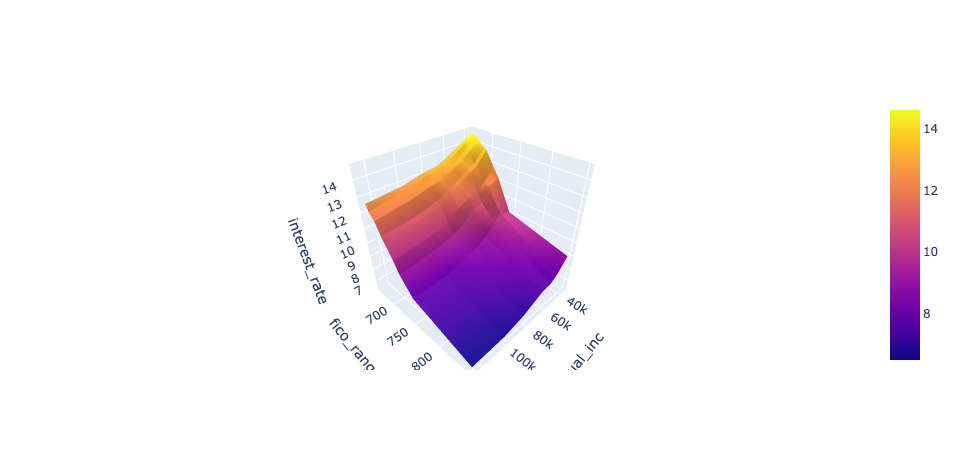

In [ ]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()

### PDP에서 카테고리특성을 사용

우리는 카테고리 특성을 학습할 때 Ordinal Encoder, Target Encoder 같은 인코더를 사용하게 됩니다. 인코딩을 하게되면 학습 후 PDP 를 그릴 때 인코딩된 값이 나오게 되어 카테고리특성의 실제 값을 확인하기 어려운 문제가 있습니다. 이번에는 PDP 에 인코딩되기 전 카테고리값을 보여주기 위한 방법을 알아 보겠습니다.

#### 이번 예시에서는 Titanic 데이터셋의 카테고리 특성을 사용해 보겠습니다

In [ ]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

df = sns.load_dataset('titanic')
df['age'] = df['age'].fillna(df['age'].median())
df = df.drop(columns='deck') # NaN 77%
df = df.dropna()

target = 'survived'
features = df.columns.drop(['survived', 'alive'])

X = df[features]
y = df[target]

In [ ]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipe.fit(X, y);

In [ ]:
encoder = pipe.named_steps['ordinalencoder']
X_encoded = encoder.fit_transform(X)
rf = pipe.named_steps['randomforestclassifier']

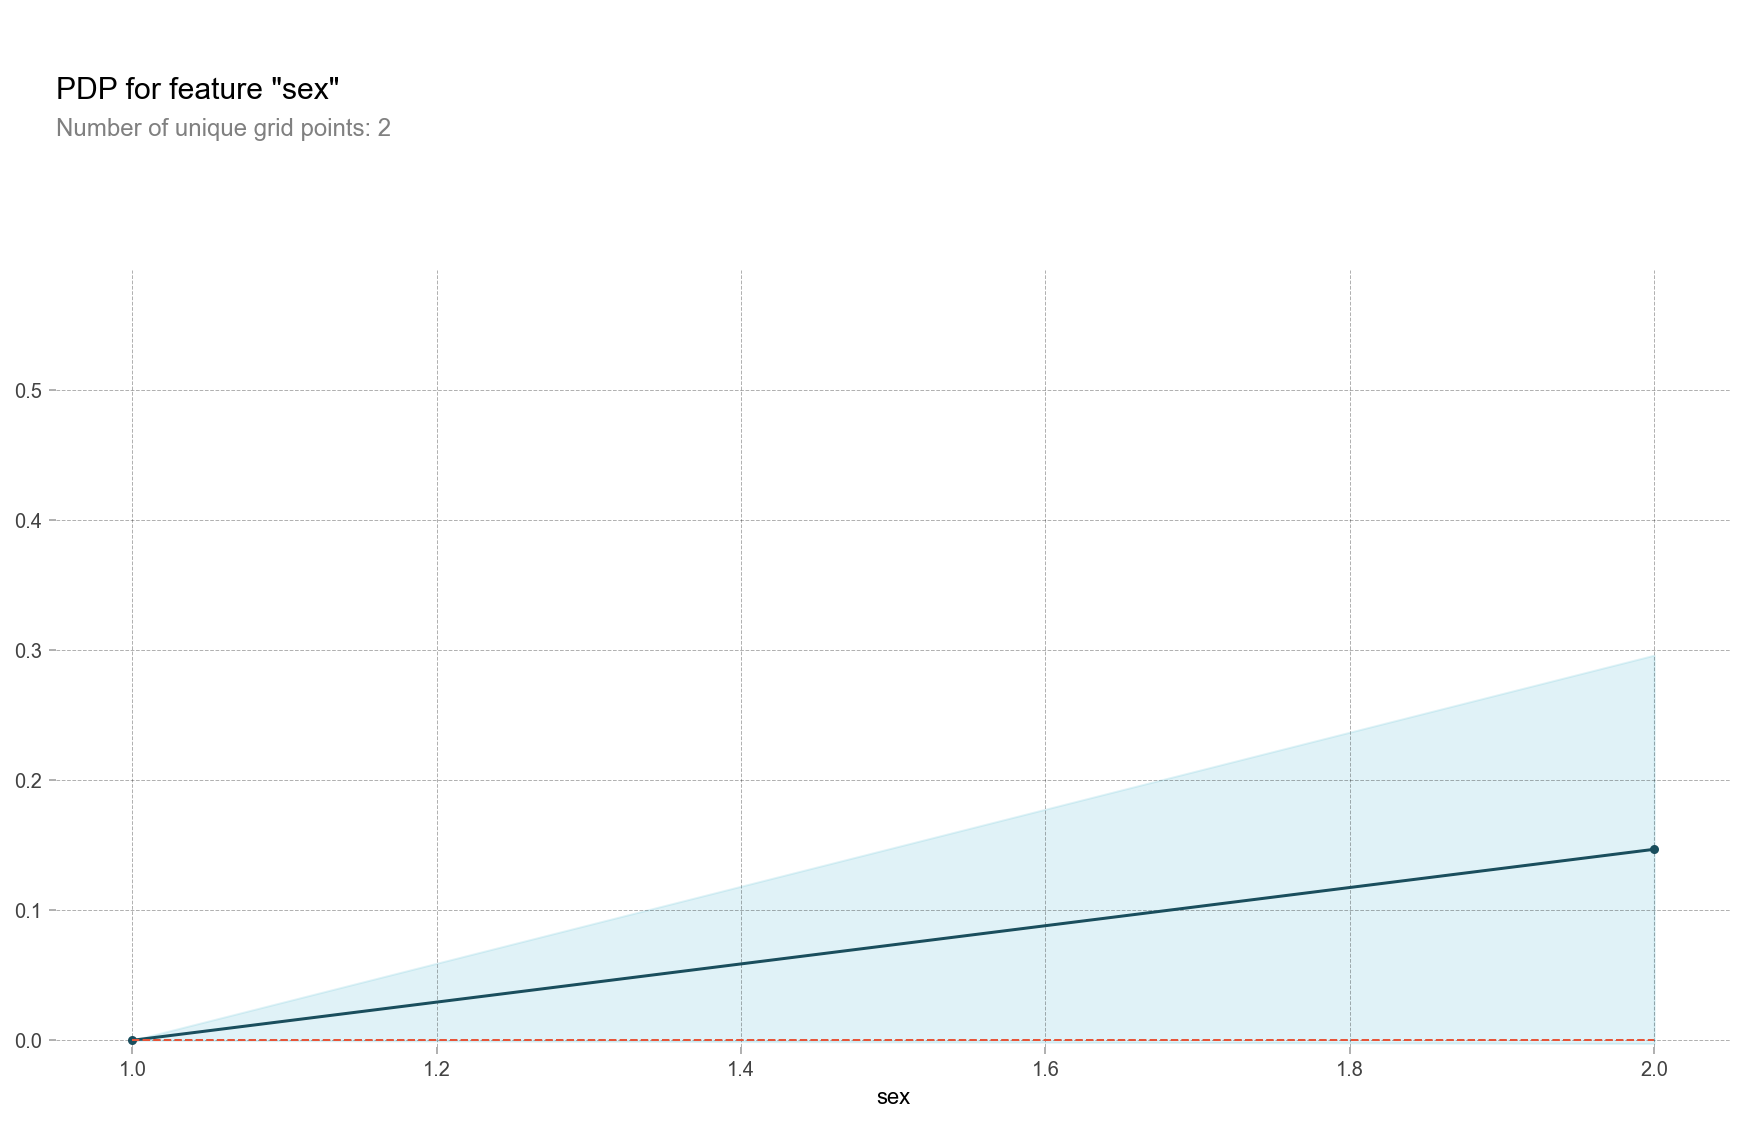

In [ ]:
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'sex'
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature); # 인코딩된 sex 값을 확인할 수 있습니다

In [ ]:
# encoder 맵핑을 확인합니다, {male:1, female:2} 로 인코딩 되어 있습니다
encoder.mapping

[{'col': 'sex',
  'mapping': male      1
  female    2
  NaN      -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 'embarked',
  'mapping': S      1
  C      2
  Q      3
  NaN   -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 'class',
  'mapping': Third     1
  First     2
  Second    3
  NaN      -2
  dtype: int64,
  'data_type': CategoricalDtype(categories=['First', 'Second', 'Third'], ordered=False)},
 {'col': 'who',
  'mapping': man      1
  woman    2
  child    3
  NaN     -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 'embark_town',
  'mapping': Southampton    1
  Cherbourg      2
  Queenstown     3
  NaN           -2
  dtype: int64,
  'data_type': dtype('O')}]

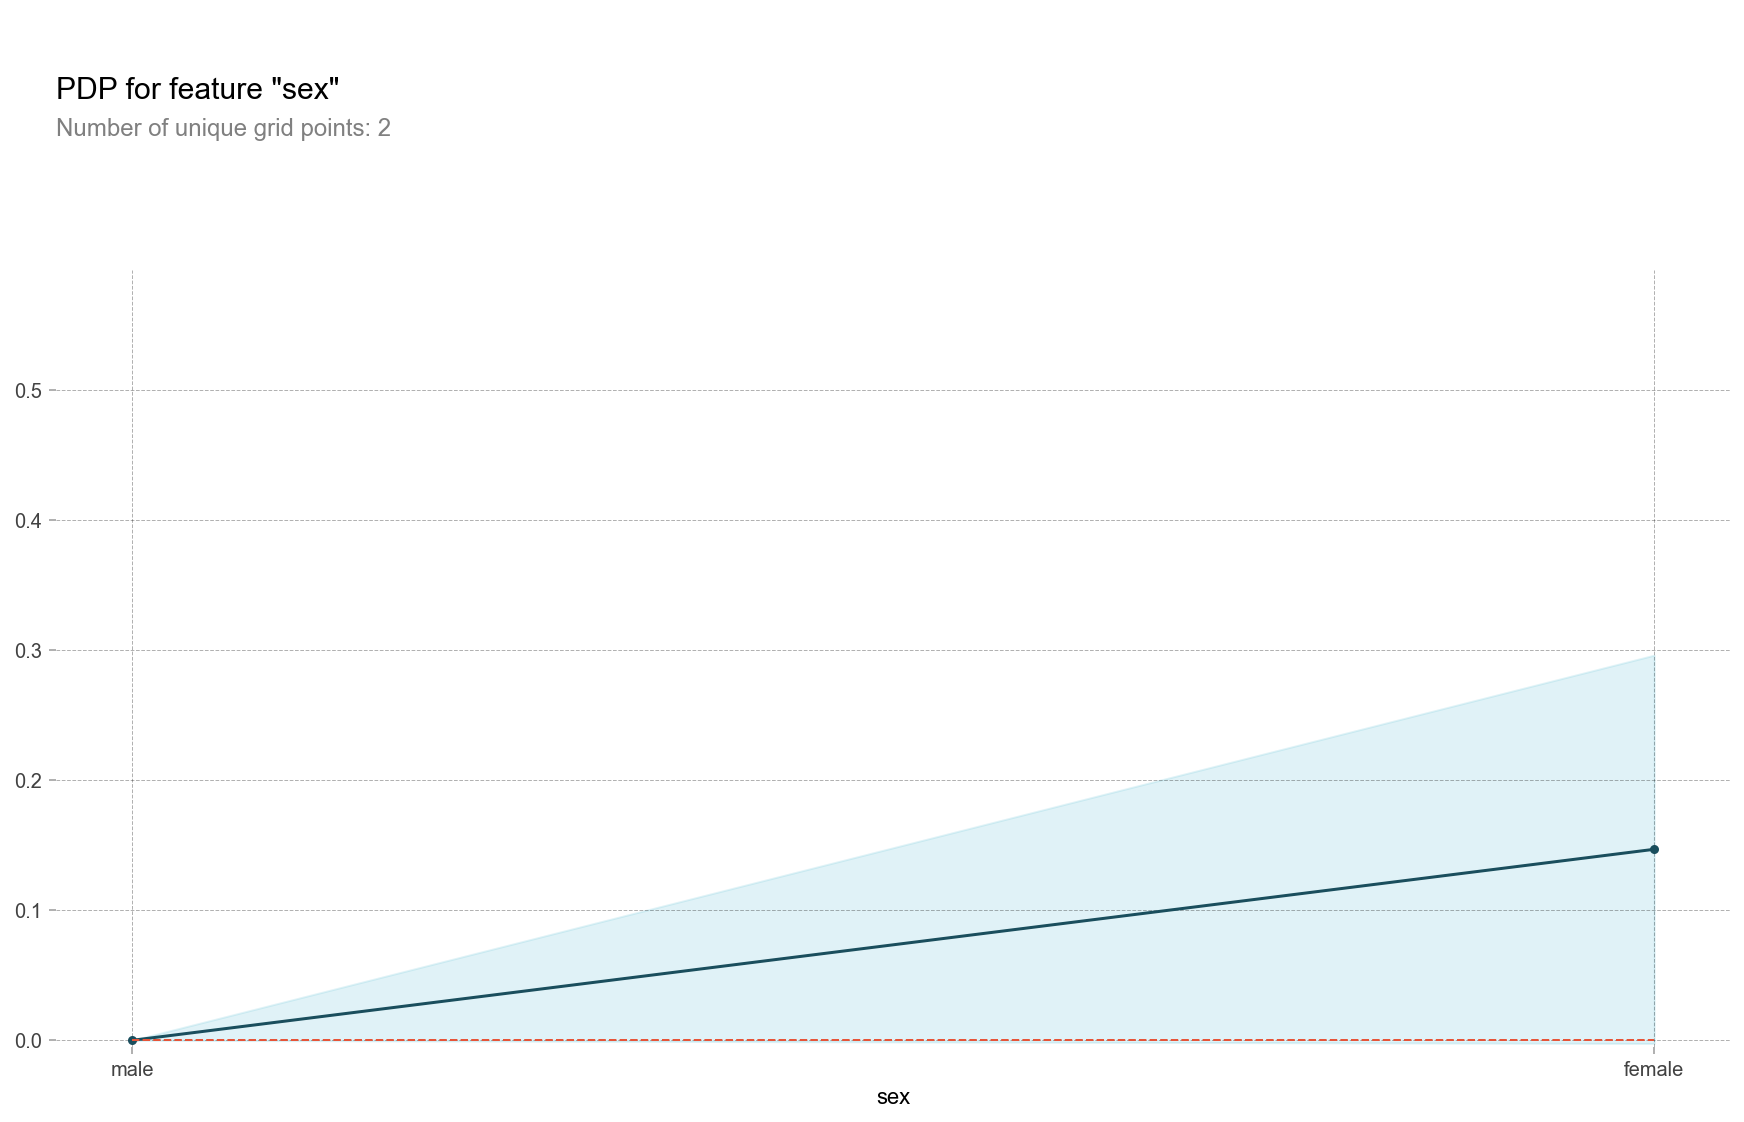

In [ ]:
pdp.pdp_plot(pdp_dist, feature)

# xticks labels 설정을 인코딩된 코드리스트와, 카테고리 값 리스트를 넣어 수동으로 해보겠습니다.
plt.xticks([1, 2], ['male', 'female',]);

In [ ]:
# 이번에는 PDP 카테고리값 맵핑을 자동으로 해보겠습니다

feature = 'sex'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

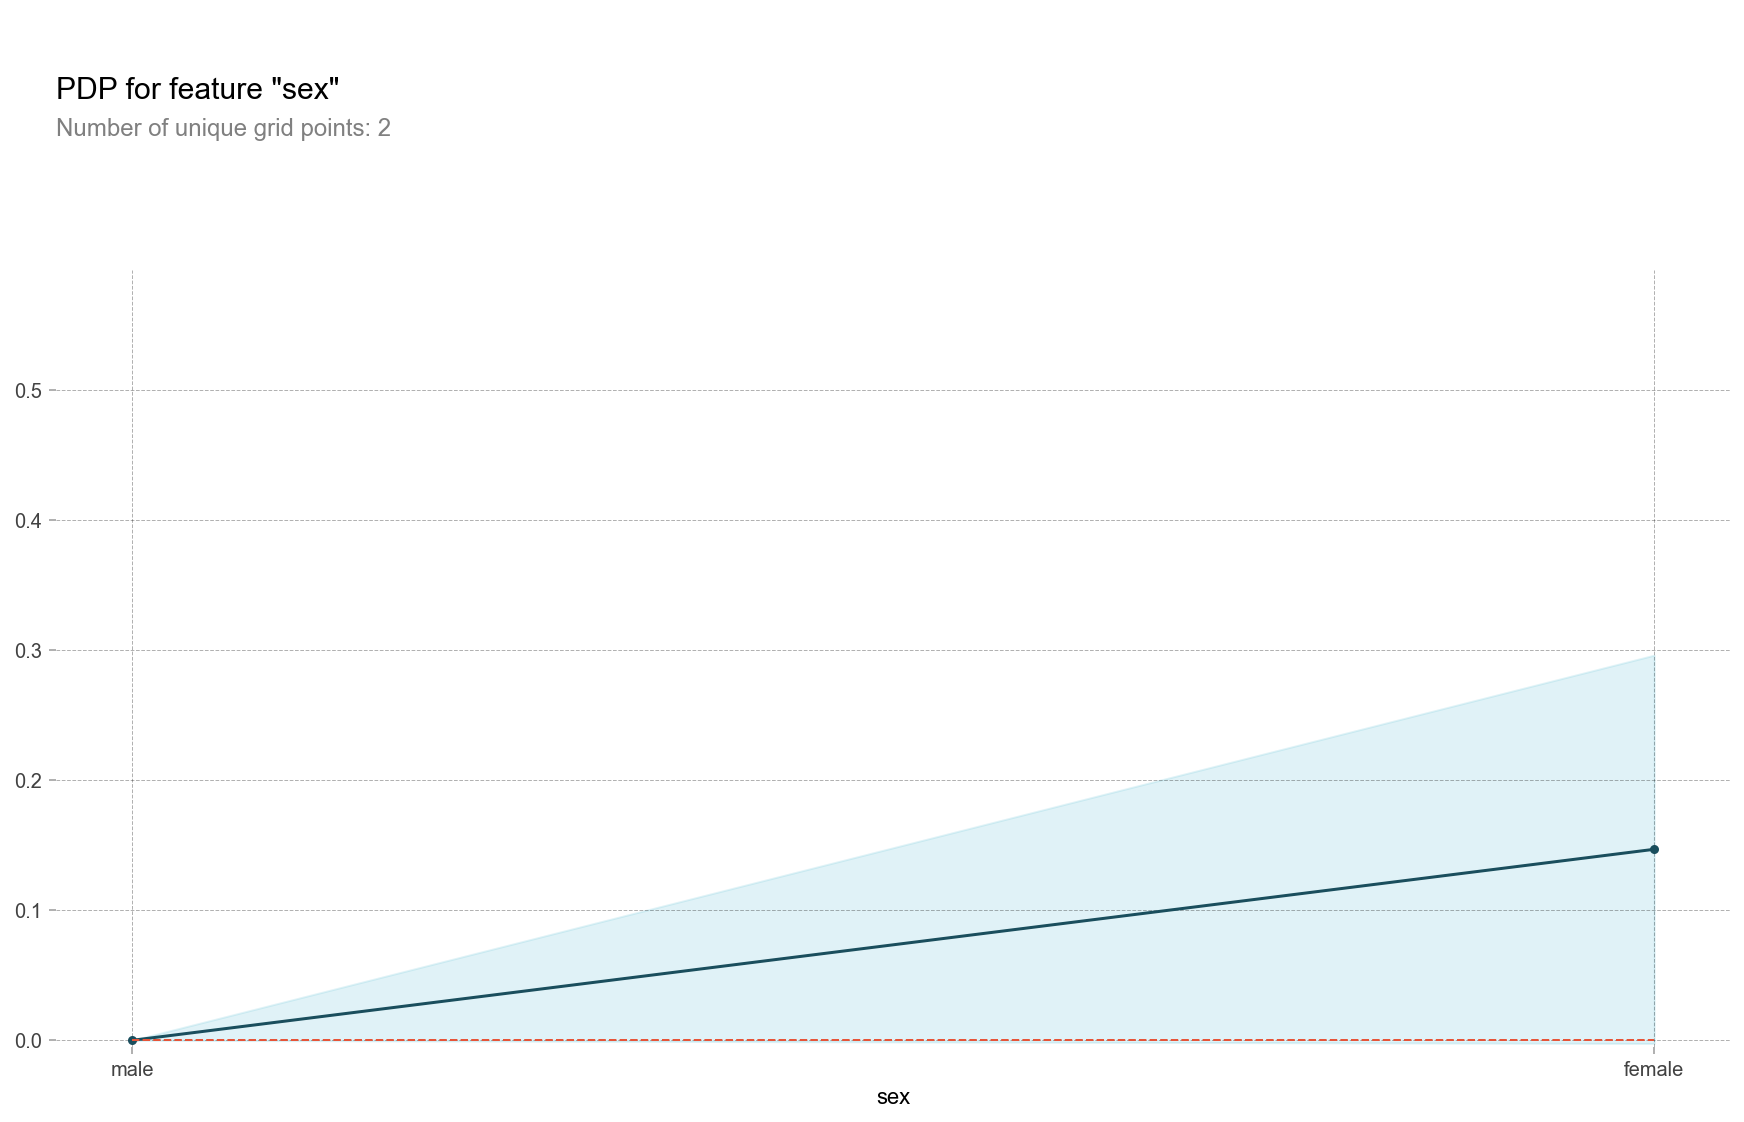

In [ ]:
pdp.pdp_plot(pdp_dist, feature)

# xticks labels 설정을 위한 리스트를 직접 넣지 않아도 됩니다 
plt.xticks(category_codes, category_names);

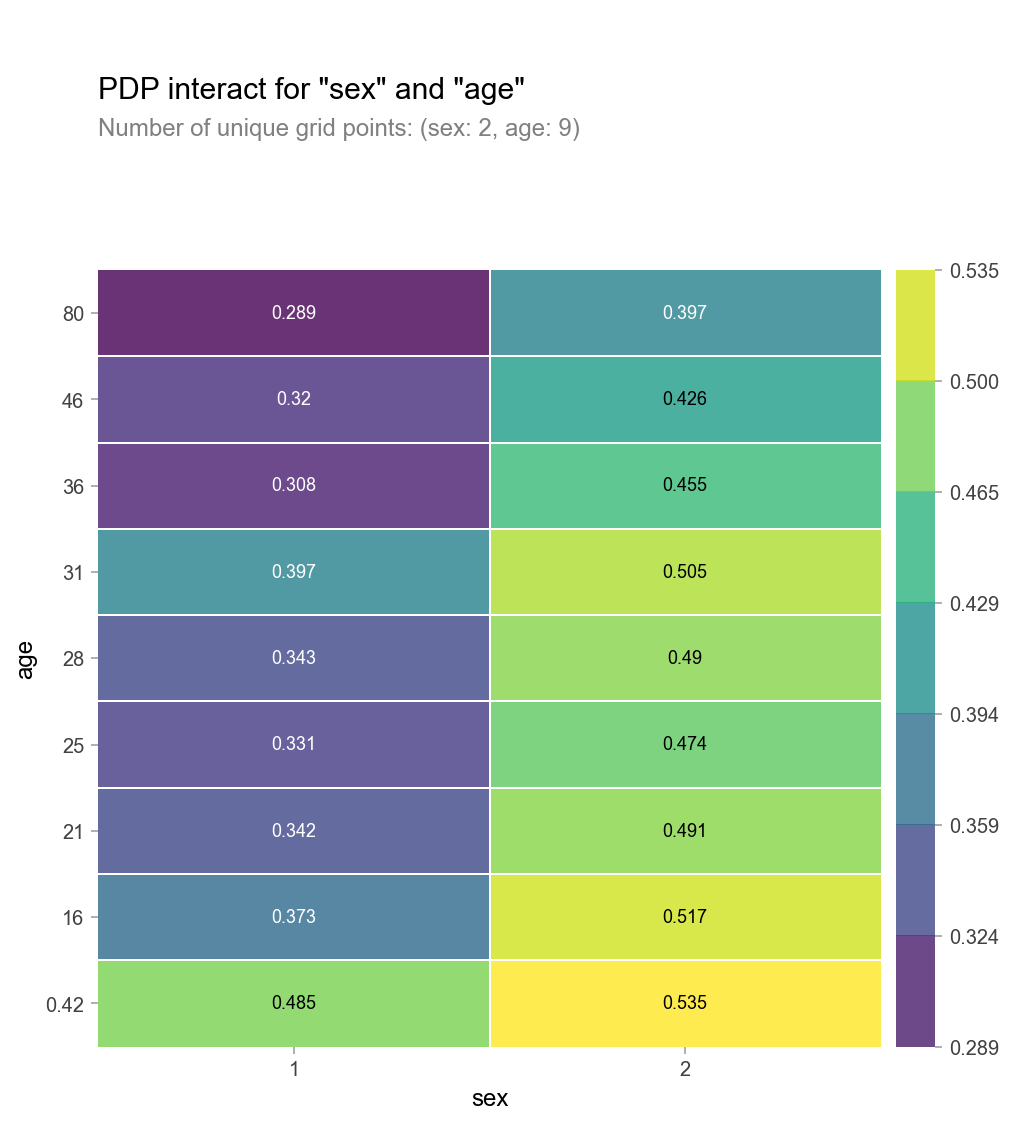

In [ ]:
# 2D PDP
features = ['sex', 'age']

interaction = pdp_interact(
    model=rf, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

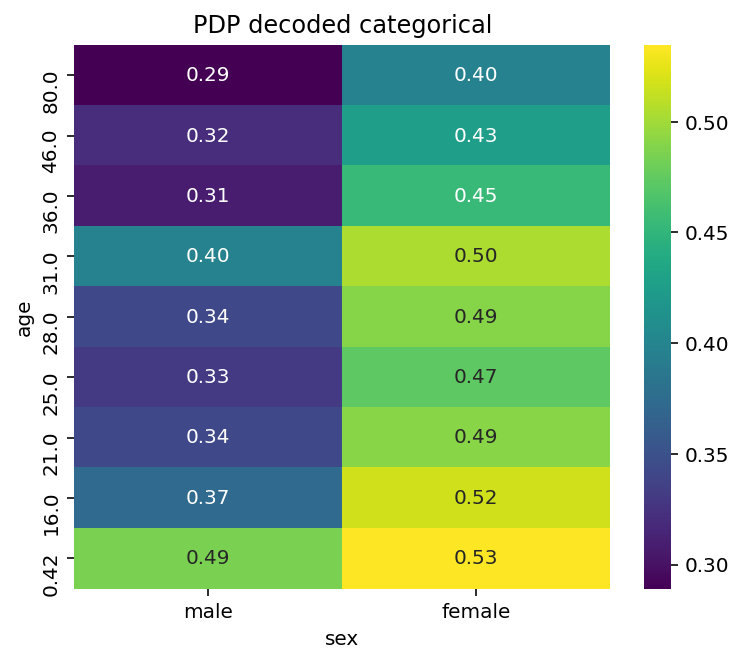

In [ ]:
# 2D PDP 를 Seaborn Heatmap으로 그리기 위해 데이터프레임으로 만듭니다
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1]

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(6,5))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('PDP decoded categorical');